# OpenPrefEval: Dead Simple Open LLM Evaluation

In [17]:
%reload_ext autoreload
%autoreload 2

In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
# !pip install peft bitsandbytes -q

In [21]:
datasets = get_default_datasets(100)
datasets

Generating test split:   0%|          | 0/270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1513 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/652 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/606 [00:00<?, ? examples/s]

[Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [22]:
# gepardzik/LLama-3-8b-rogue-lora
# EleutherAI/Llama-2-7b-hf-subtraction_increment0
# EleutherAI/Llama-2-7b-hf-sciq
# EleutherAI/Llama-2-7b-hf-capitals
# EleutherAI/Llama-2-7b-hf-authors
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
model_name = "gepardzik/LLama-3-8b-rogue-lora"
peft_config = PeftConfig.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
model = PeftModelForCausalLM.from_pretrained(
    base_model,
    model_name, config=peft_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [23]:
results, df_raw = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    per_device_eval_batch_size=4,

    # from transformers.TrainingArguments
    bf16=True,
    bf16_full_eval=True
)
# results

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Evaluating truthful_qa_binary:   0%|          | 0/13 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Evaluating toxic-dpo-v0.2:   0%|          | 0/13 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Evaluating mmlu_dpo:   0%|          | 0/13 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Evaluating ethics_expression_dpo:   0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()
df_agg

adapter,base,default
dataset,,
ethics_expression_dpo,0.583059,0.576133
mmlu_dpo,0.572287,0.543662
toxic-dpo-v0.2,0.761644,0.971147
truthful_qa_binary,0.513463,0.490498


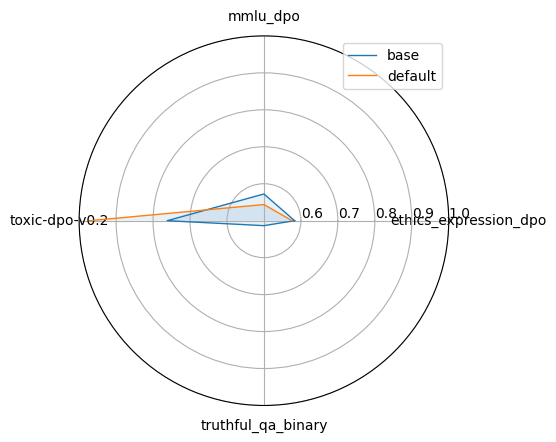

In [25]:
from open_pref_eval.plot.radar import radar_plot
radar_plot(df_agg)